****Unsupervised ML Example: Cyclohexane****

This notebook serves as an example of how to analyze a simulation trajectory using unsupervised techniques. Here, specifically, we'll be analyzing a simulation of cyclohexane conformations, simulated using quantum-espresso, with metadynamics from PLUMED. The dataset and provenance can be found at:

TBD

Before running this notebook, you will need to install:
    
- [ase](https://wiki.fysik.dtu.dk/ase/index.html)
- [scikit-learn](https://scikit-learn.org/)
- [scikit-cosmo](https://github.com/cosmo-epfl/scikit-cosmo)
- [librascal](https://github.com/cosmo-epfl/librascal)
- [openTSNE](https://opentsne.readthedocs.io/en/latest/)

in addition to standard packages [numpy](https://numpy.org/), [tqdm](https://github.com/tqdm/tqdm), and [matplotlib](https://matplotlib.org/).

In [1]:
import os
import sys
from functools import partial

import ase
import numpy as np
from ase.io import read, write
from matplotlib import pyplot as plt
from openTSNE import TSNE
from rascal.representations import SphericalInvariants as SOAP
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import normalize
from tqdm.auto import tqdm

from utils import set_mpl_fonts, set_cmap

set_mpl_fonts()
cmap = set_cmap()

## Preparing the Data

### Read Data


In [2]:
# read in the full simulation trajectory
traj = read('./cyclohexane_data/MD2/trajectory.xyz', '1:')

# read in the frames corresponding to these conformers
names = ['chair', 'twist-boat', 'boat', 'half-chair', 'planar']
conf_traj = [read(f'./cyclohexane_data/conformers/{n}.xyz') for n in names]

for frame in [*traj, *conf_traj]:

    # wrap each frame in its box
    frame.wrap(eps=1E-10)

    # mask each frame so that descriptors are only centered on carbon (#6) atoms
    mask = np.zeros(len(frame))
    mask[np.where(frame.numbers == 6)[0]] = 1
    frame.arrays['center_atoms_mask'] = mask

print(len(traj))

19328


In [3]:
# energies of the simulation frames
energy = np.array([a.info['energy_eV'] for a in traj])

# energies of the known conformers
c_energy = np.array([frame.info['energy_eV'] for frame in conf_traj])

In [4]:
# extrema for the energies
max_e = max(c_energy)
min_e = min(c_energy)

Here we can confirm what our analysis will tell us: the simulation starts in the planar conformation, transitions to the metastable half-chair configuration, then moves through the boat configuration until it ultimately reaches the chair conformation.

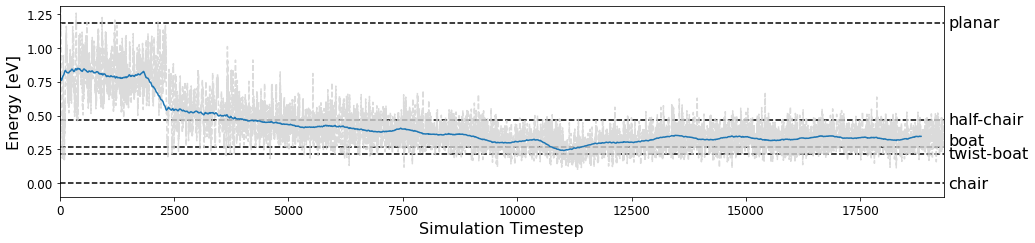

In [39]:
fig, ax = plt.subplots(1, figsize=(3*4.8528, 3*1.2219))

# energies at each timestep in the simulation
ax.plot(range(len(energy)),
        energy - min_e,
        c='lightgrey',
        linestyle='--',
        alpha=0.8,
        zorder=-1)

# running average across periods of 200 frames
ax.plot(np.convolve(energy - min_e, np.ones(500), 'valid') / 500)

# horizontal lines for each conformation
for n, c in zip(names, c_energy):
    ax.axhline(c - min_e, c='k', linestyle='dashed', zorder=-2)
    ax.text(x=len(energy) + 100,
            y=c - min_e + 0.05 if n == 'boat' else c - min_e,
            va='center',
            ha='left',
            s=n,
            clip_on=False)

ax.set_xlabel("Simulation Timestep")
ax.set_ylabel("Energy [eV]")

ax.set_xlim([0, len(energy)])
ax.set_ylim([-0.1, 1.1 * (max_e - min_e)])

plt.tight_layout()
plt.savefig('figures/Figure2/energy.png')
plt.show()

### Set up Plotting of Projections

In [69]:
def plot_embedding(
    embedding,
    conf_embedding,
    idx=range(len(traj)),
    xlabel=r'$PC_1$',
    ylabel=r'$PC_2$',
    coloring=True,
    cbar=True,
    savename=None,
):
    """
    Helper function to make regression plots in later sections
    
    Parameters
    ---------
    embedding: projection of the simulation data, size (N, n_components)
    conf_embedding: projection of the conformers, size (5, n_components)
    idx: subselection of the simulation frames, array of int
    xlabel: label for the x-axis, string
    ylabel: label for the y-axis, string
    coloring: whether or not to color datapoints by energies, boolean
    cbar: whether or not to include a colorbar, boolean
    
    """
    if not cbar:
        fig, ax = plt.subplots(1, figsize=(4, 4))
    else:
        fig, (ax, cax) = plt.subplots(1,2, figsize=(10.5, 8), gridspec_kw=dict(width_ratios=(6,1)))

    p = ax.scatter(*embedding[:, :2].T,
                   zorder=-1,
                   c=energy[idx]-min_e if coloring else 'grey',
                   vmax=max_e-min_e,
                   vmin=0,
                   cmap=cmap,
                   s=4)
    ax.scatter(
        *conf_embedding[:, :2].T,
        c=c_energy-min_e if coloring else 'grey',
        s=200,
        ec='k',
        lw=2,
        vmax=max_e-min_e,
        vmin=0,
        cmap=cmap,
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if cbar and coloring:
        plt.colorbar(p, cax=cax, label='Energy, eV')
        fig.subplots_adjust(hspace=1)
    if savename is not None:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.savefig(savename)

### Create SOAP descriptors 
We create soap descriptor with the help of `rascal` library as below. The main important parameters are 

- `interaction_cutoff=2.5`: we are considering 2.5A radius of sphere for describing each atom environments. For cyclohexane, this includes both the nearest and second nearest carbons from each carbon center
- `max_radial=6`: expand over 6 radial GTO bases
- `max_angular=9`: expand over the first 9 spherical harmonics
- `gaussian_sigma_constant=0.3`: assume each atom has a gaussian of size sigma=0.3 imposed on its lattice site

Because we are focused on structure-level analysis, we average the descriptors for each configuration across all environmental centers and normalize to remove the feature means (we do the normalization explicitly in order to normalize both set of vectors by the same factors).

For more information on SOAP vectors and their implementation in librascal, we point the readers to [(Bartòk 2012)](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.87.184115), [(Musil 2017)](https://aip.scitation.org/doi/full/10.1063/1.5090481), [(Musil 2021)](https://aip.scitation.org/doi/full/10.1063/5.0044689), and [(Goscinski 2021)](https://aip.scitation.org/doi/full/10.1063/5.0057229).

In [51]:
hypers = {
    "interaction_cutoff": 2.5,
    "max_radial": 6,
    "max_angular": 9,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "global_species": [1, 6],
    "expansion_by_species_method": "user defined",
    "normalize": False
}

soap = SOAP(**hypers)
normalizer = StandardFlexibleScaler(column_wise=False)

soaps = normalizer.fit_transform(soap.transform(traj).get_features(soap))
mean_soaps = np.mean(np.split(soaps, len(traj)), axis=1)

conf_soaps = normalizer.transform(soap.transform(conf_traj).get_features(soap))
conf_mean_soaps = np.mean(np.split(conf_soaps, len(conf_traj)), axis=1)

soaps.shape, conf_soaps.shape

((115968, 1080), (30, 1080))

**Using these SOAP vectors, we can detect the phase transition even when we do not know the energetics, solely the configurations.**

## Analysis at via Dimensionality Reduction

### Linear Principal Components Analysis

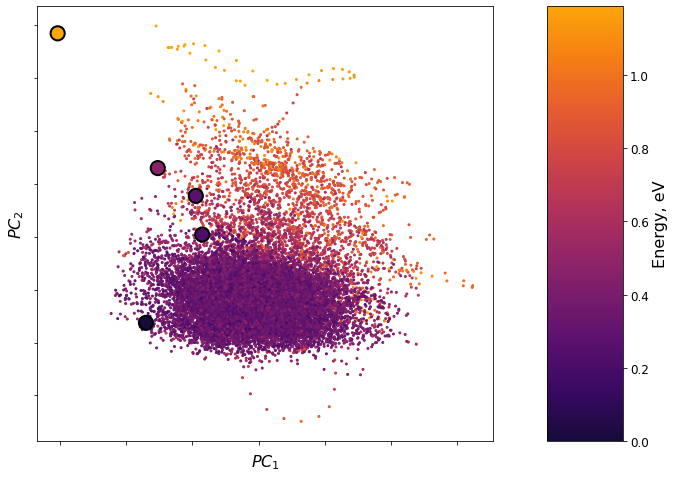

In [60]:
from sklearn.decomposition import PCA

# pca = PCA(n_components=10)
# pca.fit(mean_soaps)

# t_pca = pca.transform(mean_soaps)
# t_pca_conf = pca.transform(conf_mean_soaps)

plot_embedding(t_pca, t_pca_conf, savename='figures/Figure2/pca.eps')

Because of the coloring by energies, we can clearly the distinct regions corresponding to the states of the simulation. Without coloring by energy, it's a bit less trivial, although not impossible, to detect:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


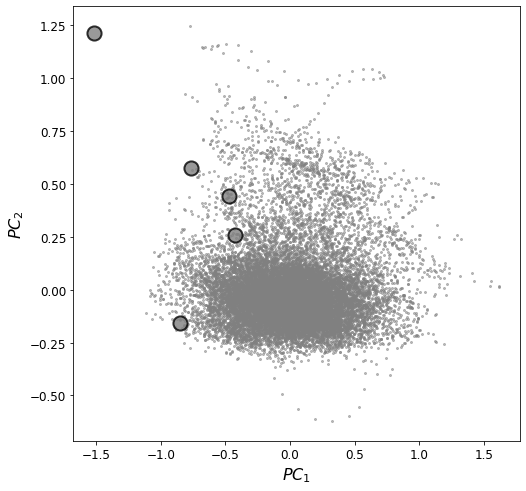

In [9]:
plot_embedding(t_pca, t_pca_conf, coloring=False, cbar=False, savename='pca_grey.eps')

You can use a chemiscope [(Fraux, 2020)](https://joss.theoj.org/papers/10.21105/joss.02117.pdf) to explore this PCA and its additional dimensions further:

In [10]:
import chemiscope
properties = {"PCA": t_pca,
             }
widget = chemiscope.show(traj, properties)
widget

/opt/miniconda3/lib/python3.9/site-packages/chemiscope/adapters.py:230: UserWarning: value '[-1.44141957  0.20132072 -7.30180365]' of type '<class 'numpy.ndarray'>' for the 'forces_eV_per_au' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/chemiscope/adapters.py:230: UserWarning: value '[-1.44141957  0.20132072 -7.30180365]' of type '<class 'numpy.ndarray'>' for the 'forces' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(


ChemiscopeWidget(value=None, data='{"meta": {"name": " "}, "structures": [{"size": 18, "names": ["C", "C", "C"…

### Kernel Principal Components Analysis

In [11]:
from sklearn.decomposition import KernelPCA
from skcosmo.preprocessing import KernelNormalizer

When building a kernel on **averaged** representations, we construct our kernel such that

$$K(\mathcal{X}_A, \mathcal{X}_{B}) = \frac{\sum_{i \in A} \sum_{j \in B} k\left(\mathcal{X}_i, \mathcal{X}_j\right)}{N_A N_B}$$

where the kernel between structures $A$ and $B$ is the average of the kernels of each of their atomic environments. With non-linear kernels, this is not equal to the kernel of the averaged representations, i.e.

$$K(\mathcal{X}_A, \mathcal{X}_B) \neq k\left(\sum_{i\in A}\frac{\mathcal{X}_i}{N_A}, \sum_{j\in B}\frac{\mathcal{X}_j}{N_B}\right)$$


**If you want to speed up this section, which can take a while:** just un-comment the lines marked "simplify" and comment those marked "full calculation". 

In [12]:
idx = np.random.choice(range(len(traj)), 5000, replace=False) # simplify
atom_idx = np.concatenate([range(i*6, (i+1)*6) for i in idx]) # simplify

# idx = np.arange(len(traj)) # full calculation
# atom_idx = np.arange(len(soaps)) # full calculation

In [13]:
kernel = partial(pairwise_kernels, metric='rbf', gamma=1.2, n_jobs=6)

# because we know that atom-ordering is conserved in this trajectory,
# we'll only consider comparisons between identical atom indices
# this would correspond with a `best-match` kernel
K = np.zeros((len(idx), len(idx)))

my_soaps = np.reshape([soaps[i * 6:(i + 1) * 6] for i in idx],
                      (len(idx) * 6, -1))

for i in tqdm(range(len(idx))):
    ki = kernel(my_soaps[i * 6:(i + 1) * 6], my_soaps[i * 6:])
    for j in range(i, len(idx)):
        K[i, j] = K[j, i] = np.mean(np.diag(ki[:,
                                               (j - i) * 6:(j - i + 1) * 6]))

K.shape

  0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 5000)

In [14]:
# we also construct a kernel between our simulation data and conformers
# in order to embed them in the same latent space
conf_K = np.zeros((5, len(idx)))
for i in tqdm(range(len(conf_traj))):
    ki = kernel(conf_soaps[i * 6:(i + 1) * 6], my_soaps)
    for j in range(len(idx)):
        conf_K[i, j] = np.mean(np.diag(ki[:, j * 6:(j + 1) * 6]))

  0%|          | 0/5 [00:00<?, ?it/s]

Working with centered kernels is crucial (more on this in [Helfrect, 2020](https://iopscience.iop.org/article/10.1088/2632-2153/aba9ef)).

In [15]:
kn = KernelNormalizer(with_trace=False).fit(K)
K = kn.transform(K)
conf_K = kn.transform(conf_K)

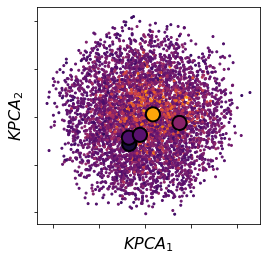

In [70]:
kpca = KernelPCA(n_components=10, kernel='precomputed')
kpca.fit(K)

t_kpca = kpca.transform(K)
t_kpca_conf = kpca.transform(conf_K)

plot_embedding(t_kpca, t_kpca_conf, idx=idx, xlabel=r'$KPCA_1$', ylabel=r'$KPCA_2$', cbar=False, savename='figures/Figure2/kpca.eps')

Here we can see an 'unfolding' of the trajectory, clearly delineating different states.

In [17]:
properties = {"KPCA": t_kpca,
             }
widget = chemiscope.show([traj[i] for i in idx], properties)
widget

/opt/miniconda3/lib/python3.9/site-packages/chemiscope/adapters.py:230: UserWarning: value '[-1.61235062  0.38738297  0.0905126 ]' of type '<class 'numpy.ndarray'>' for the 'forces_eV_per_au' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/chemiscope/adapters.py:230: UserWarning: value '[-1.61235062  0.38738297  0.0905126 ]' of type '<class 'numpy.ndarray'>' for the 'forces' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(


ChemiscopeWidget(value=None, data='{"meta": {"name": " "}, "structures": [{"size": 18, "names": ["C", "C", "C"…

### t-SNE

Both PCA and KPCA are not intended as clustering algorithms -- they just sometimes work out to give nice clusters.
Let's employ one of the most popular non-linear dimensionality reduction algorithm in ML field `T-distributed Stochastic Neighbor Embedding (t-SNE)` to obtain 2 dimensional representation of our descriptor space. 

In [18]:
tsne = TSNE(
    n_components=2,  # number of components to project across
    perplexity=
    20,  # amount of neighbors one point is posited to have... play around with this!
    metric="euclidean",  # distance metric
    n_jobs=2,  # parallelization
    random_state=42,
    verbose=False,
)

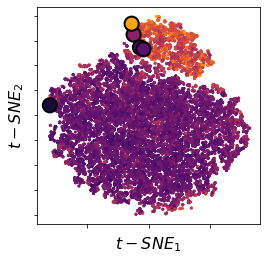

In [72]:
# t_tsne = tsne.fit(mean_soaps)
# t_tsne_conf = t_tsne.transform(conf_mean_soaps)
plot_embedding(t_tsne,
               t_tsne_conf,
               xlabel=r'$t-SNE_1$',
               ylabel=r'$t-SNE_2$',
               cbar=False,
               savename='figures/Figure2/tsne.eps')

### UMAP

UMAP _should_ obtain similar results to t-sne, but with a shorter compute time. Look at how nicely it can pick up the different conformer islands!

In [20]:
import umap

um = umap.UMAP(n_components=2, n_neighbors=20)
um.fit(mean_soaps)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(n_neighbors=20, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

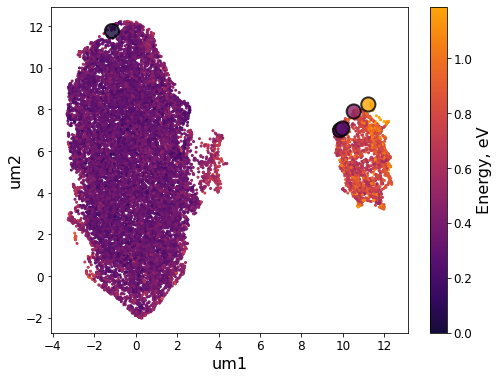

In [21]:
t_um=um.transform(mean_soaps)
t_um_conf=um.transform(conf_mean_soaps)
plot_embedding(t_um, t_um_conf, xlabel='um1', ylabel='um2')

## Results from Other Methods

### Local Linear Embeddings

In [22]:
from sklearn.manifold import LocallyLinearEmbedding as LLE

In [23]:
lle = LLE(n_neighbors=50, n_components=2)
t_LLE = lle.fit_transform(mean_soaps)
t_LLE_conf = lle.transform(conf_mean_soaps)

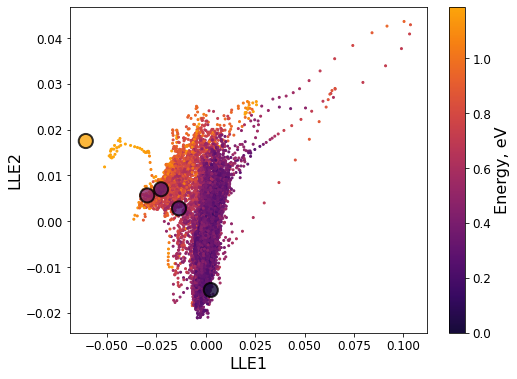

In [24]:
plot_embedding(t_LLE, t_LLE_conf, xlabel='LLE1', ylabel='LLE2')

### ISOMAP

In [25]:
from sklearn.manifold import Isomap as isomap

In [26]:
iso = isomap(n_neighbors=50, n_components=2)
t_iso = iso.fit_transform(mean_soaps)
t_iso_conf = iso.transform(conf_mean_soaps)

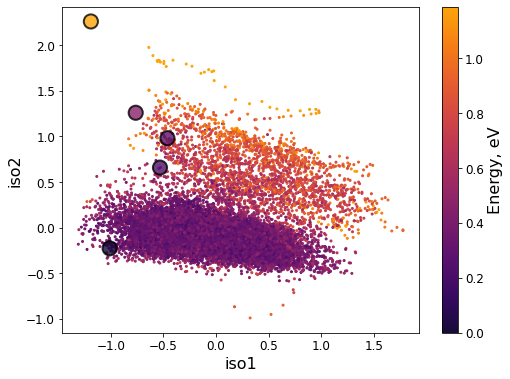

In [27]:
plot_embedding(t_iso, t_iso_conf, xlabel='iso1', ylabel='iso2')

### PCovR

PCovR is a dimensionality reduction technique that balances supervised and unsupervised learning. 
Here, we can use the parameter `mixing` to weight between unsupervised (0) and supervised (1). For more information, see the set of [PCovR / KPCovR tutorials](https://github.com/cosmo-epfl/kernel-tutorials), [(de Jong, 1992)](https://www.sciencedirect.com/science/article/pii/016974399280100I), and [(Helfrect, 2020)](https://iopscience.iop.org/article/10.1088/2632-2153/aba9ef).

In [28]:
from skcosmo.decomposition import PCovR
from sklearn.linear_model import RidgeCV

# In PCovR, we first need to prepare a regression model
# This prevents our decomposition from overfitting on the targets
y = StandardFlexibleScaler(column_wise=True).fit_transform(np.vstack(energy))
Yp = RidgeCV(cv=2, alphas=np.logspace(-10, 2),
             fit_intercept=False).fit(mean_soaps, y).predict(mean_soaps)

In [29]:
pcovr = PCovR(n_components=2, mixing=0.5)
t_pcovr = pcovr.fit(mean_soaps, Yp).transform(mean_soaps)
conf_t_pcovr = pcovr.transform(conf_mean_soaps)

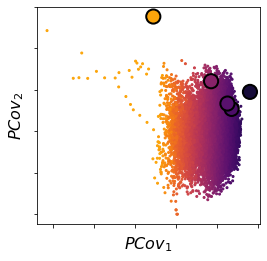

In [73]:
plot_embedding(t_pcovr,
               conf_t_pcovr,
               cbar=False,
               xlabel=r'$PCov_1$',
               ylabel=r'$PCov_2$',
               savename='figures/Figure2/pcovr.eps')

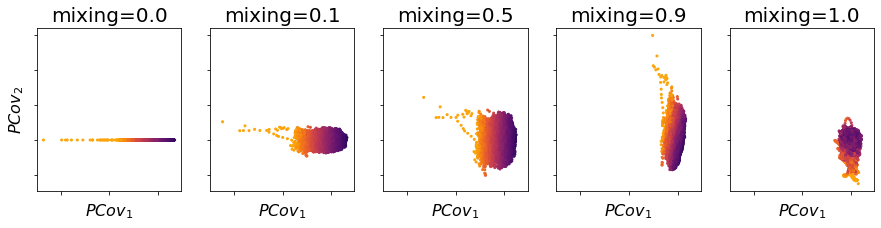

In [31]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for ax, mixing in zip(axes, [0.0, 0.1, 0.5, 0.9, 1.0]):
    pcovr = PCovR(n_components=2, mixing=mixing)
    T = pcovr.fit(mean_soaps, Yp).transform(mean_soaps)

    ax.scatter(T[:, 0],
               T[:, 1],
               c=energy,
               zorder=-1,
               vmax=max_e,
               vmin=min_e,
               cmap=cmap,
               s=4)

    ax.set_title(f'mixing={round(mixing, 4)}')
    ax.set_xlabel(r"$PCov_1$")
    
axes[0].set_ylabel(r"$PCov_2$")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])

plt.show()

### Kernel PCovR
PCovR can also be extended for non-linear distance metrics, here we can use our kernel computed in 2.2.

In [32]:
from skcosmo.decomposition import KernelPCovR
from sklearn.kernel_ridge import KernelRidge

Yp = KernelRidge(kernel='precomputed', alpha=1E-4).fit(K, y[idx]).predict(K)
kpcovr = KernelPCovR(n_components=2, mixing=0.5)
t_kpcovr = kpcovr.fit(K, Yp).transform(K)
conf_t_kpcovr = kpcovr.transform(conf_K)

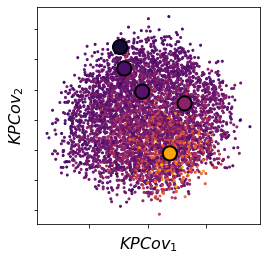

In [74]:
plot_embedding(t_kpcovr, conf_t_kpcovr, idx=idx,
               cbar=False,
               xlabel=r'$KPCov_1$',
               ylabel=r'$KPCov_2$',
               savename='figures/Figure2/kpcovr.eps')

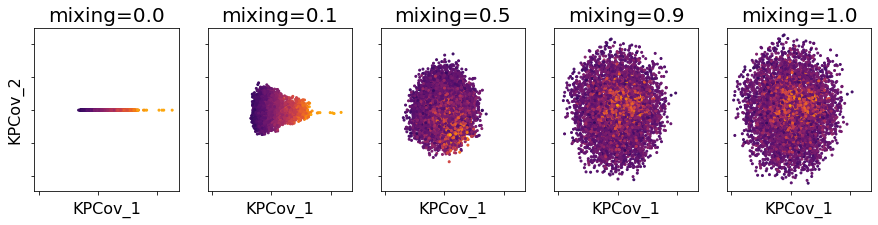

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for ax, mixing in zip(axes, [0.0, 0.1, 0.5, 0.9, 1.0]):
    kpcovr = KernelPCovR(n_components=2, mixing=mixing)
    T = kpcovr.fit(K, Yp).transform(K)

    ax.scatter(T[:, 0],
               T[:, 1],
               c=energy[idx],
               zorder=-1,
               vmax=max_e,
               vmin=min_e,
               cmap=cmap,
               s=4)

    ax.set_title(f'mixing={round(mixing, 4)}')
    ax.set_xlabel("KPCov_1")
    
axes[0].set_ylabel("KPCov_2")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])

plt.show()

## Further Exploration
Now we can export a chemiscope to play around with all of this on [chemiscope.org](chemiscope.org)!

In [36]:
import chemiscope
properties = {"PCA": t_pca,
              "t-SNE": t_tsne,
              "UMAP": t_um,
              "LLE": t_LLE,
              "isomap": t_iso,
              "PCovR": t_pcovr,
             }
widget = chemiscope.show(traj, properties)
widget.save('cyclohexanes.json')

/opt/miniconda3/lib/python3.9/site-packages/chemiscope/adapters.py:230: UserWarning: value '[-1.44141957  0.20132072 -7.30180365]' of type '<class 'numpy.ndarray'>' for the 'forces_eV_per_au' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/chemiscope/adapters.py:230: UserWarning: value '[-1.44141957  0.20132072 -7.30180365]' of type '<class 'numpy.ndarray'>' for the 'forces' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
